# Import Modules 

In [12]:
from model.gen import OrGAN
from model.dnet import CNN
from utils.dataset import RXrayDataset
from utils.evaluate import * 
from torch.utils.data import DataLoader 
from torch.utils.data import random_split 
from tqdm import tqdm 
import torch
import torch.nn.functional as F 
import albumentations as A 
import imageio
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import torch.nn as nn
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
import pydicom as di

from torchinfo import summary


# PSNR function

In [2]:
def PSNR(original, pred):
    mse = np.mean((original - pred) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    PSNR = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
    return PSNR

def standardize(img,m,s):
    
    if m==0 and s==0:
        m = img.mean()
        s = img.std()
    
    img = (img - m)/s
    
    return img, m, s

def unstandardize(img, m, s):
    
    img = img*s + m
    
    return img

# Parameter Set

# DATASET Defining

In [3]:
transform = A.Compose(
    [
        A.Resize(width=512, height=512, p=1.0)
    ]
)

In [ ]:
BATCH_SIZE_TEST = 1
test_xray_directory = 'data/Xray_real/real'
test_xray_filenames = os.listdir(test_xray_directory)
dataset_test = RXrayDataset(test_xray_filenames,test_xray_directory,transform = transform)

In [5]:
test_loader = DataLoader(dataset_test, BATCH_SIZE_TEST, shuffle = False)

# Model Creation

In [6]:
model = OrGAN()

# Inference on Real Xray

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model= nn.DataParallel(model,device_ids = [0])
model  = torch.load('model_weights/best.ckpt')
model = model.to(device)

In [8]:
model.eval()
preds = []
xray = []
i = 0 
for batch, (images) in enumerate(test_loader):
    images = images.to(device=device, dtype=torch.float32)
    with torch.no_grad():
        mask_pred, _ = model(images)
        images = images.cpu().detach().numpy().squeeze(0).squeeze(0)
        mask_pred = mask_pred.cpu().detach().numpy().squeeze(0).squeeze(0)
        
        preds.append(mask_pred)
        xray.append(images)
        i = i + 1

In [9]:
image = []
for x in range(len(preds)):
    im = xray[x]
    image.append(im)
    image.append(preds[x])


In [10]:
img=image[:99]

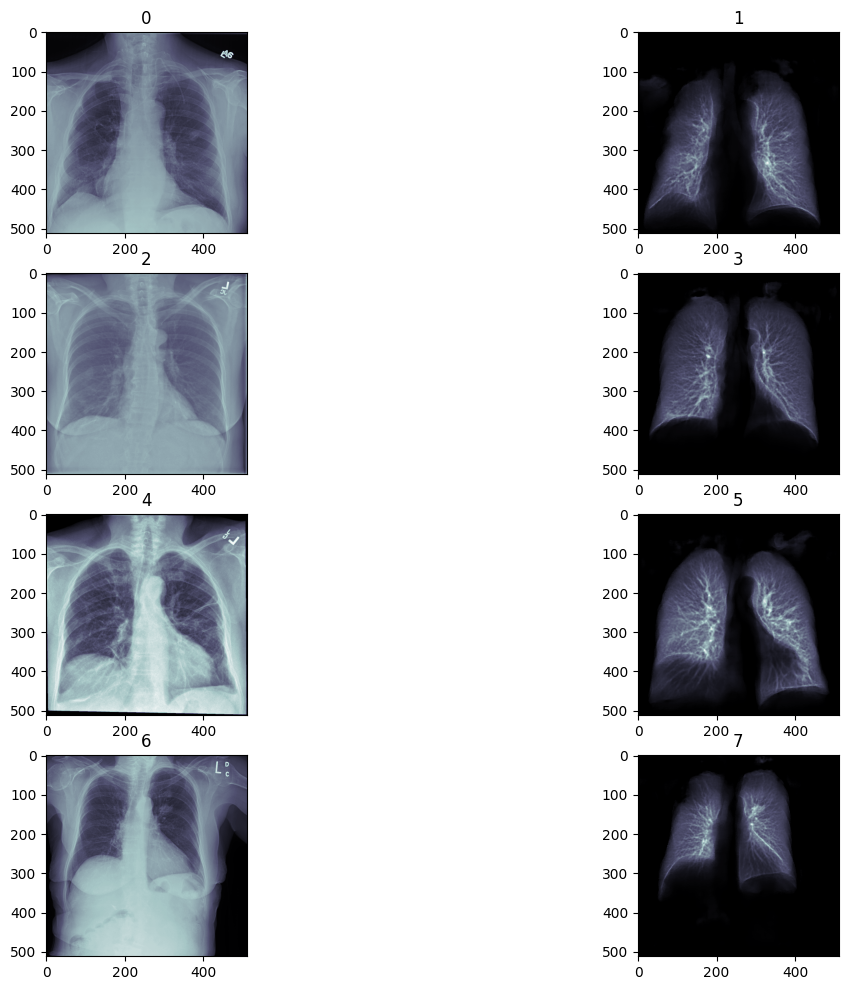

In [11]:
#plot_images(images, cols=3)
cols = 2
rows = math.ceil(len(img)/cols)
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(14,3*rows))

idx = 0
for row in ax:
    for col in row:
        if idx > len(img)-1:
            break 
        im = img[idx]
        col.imshow(im, cmap=plt.cm.bone)
        col.title.set_text(idx)
        idx += 1
plt.show()